This notebook studies the applicability of b/c-tagging event vetoes on background samples.

For 102x, [central Btag recommendations](https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X) provide working points for DeepCSV and DeepFlavour.

In [15]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot
import awkward

import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.correction import (get_pu_weights_function,
                                          get_ttbar_weight,
                                          get_nlo_weight_function)

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
import json
datasets_=json.load(open('../Samples/backgrounds_nonempty.json'))
scales_=json.load(open('../Samples/backgrounds_scale.json'))

# flatten datasets
datasets = {}
for group in datasets_:
    for tag in datasets_[group]:
        datasets[tag] = datasets_[group][tag]

# flatten scales
scales = {}
for group in scales_:
    for tag in scales_[group]:
        scales[tag] = scales_[group][tag]

lumi = 59.74*1e3
for k in scales:
    scales[k] *= lumi

# mapping
mapping = {}
for k in datasets_: mapping[k] = list(datasets_[k])

**b tagger**

|       | loose | medium | tight |
|-------|-------|--------|-------|
|DeepCSV|0.1241 | 0.4184 | 0.7527|
|DeepJet|0.0494 | 0.2770 | 0.7264|

In [32]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        quality_axis = hist.Cat('wp', 'working points')
        tagger_axis = hist.Cat('tagger', 'tagger name')
        multiplicity_axis = hist.Bin('multi', '#b-tagged/event', 6, 0, 6)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist('#counts', dataset_axis, quality_axis, tagger_axis, multiplicity_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'].content,
                    py=df['gen_p4.fCoordinates.fY'].content,
                    pz=df['gen_p4.fCoordinates.fZ'].content,
                    energy=df['gen_p4.fCoordinates.fT'].content,
                    pid=df['gen_pid'].content,
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        deepcsv_b = df['hftagscore_DeepCSV_b']
        deepjet_b = df['hftagscore_DeepFlavour_b']
        
        output['multi'].fill(dataset=dataset, tagger='DeepCSV', wp='loose', 
                             multi=deepcsv_b[deepcsv_b>0.1241].counts, weight=weight)
        output['multi'].fill(dataset=dataset, tagger='DeepCSV', wp='medium', 
                             multi=deepcsv_b[deepcsv_b>0.4184].counts, weight=weight)
        output['multi'].fill(dataset=dataset, tagger='DeepCSV', wp='tight', 
                             multi=deepcsv_b[deepcsv_b>0.7527].counts, weight=weight)
        
        output['multi'].fill(dataset=dataset, tagger='DeepJet', wp='loose', 
                             multi=deepjet_b[deepjet_b>0.0494].counts, weight=weight)
        output['multi'].fill(dataset=dataset, tagger='DeepJet', wp='medium', 
                             multi=deepjet_b[deepjet_b>0.2770].counts, weight=weight)
        output['multi'].fill(dataset=dataset, tagger='DeepJet', wp='tight', 
                             multi=deepjet_b[deepjet_b>0.7264].counts, weight=weight)
        
        return output
    
    def postprocess(self, accumulator):
        accumulator['multi'].scale(scales, axis='dataset')
        accumulator['multi_cat'] = accumulator['multi'].group("dataset",
                                                              hist.Cat("cat", "datasets"),
                                                              mapping)
        
        return accumulator

In [33]:
output = processor.run_uproot_job(datasets,
                                  treename="ffNtuplizer/ffNtuple",
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 4268/4268 [06:22<00:00, 11.15items/s]


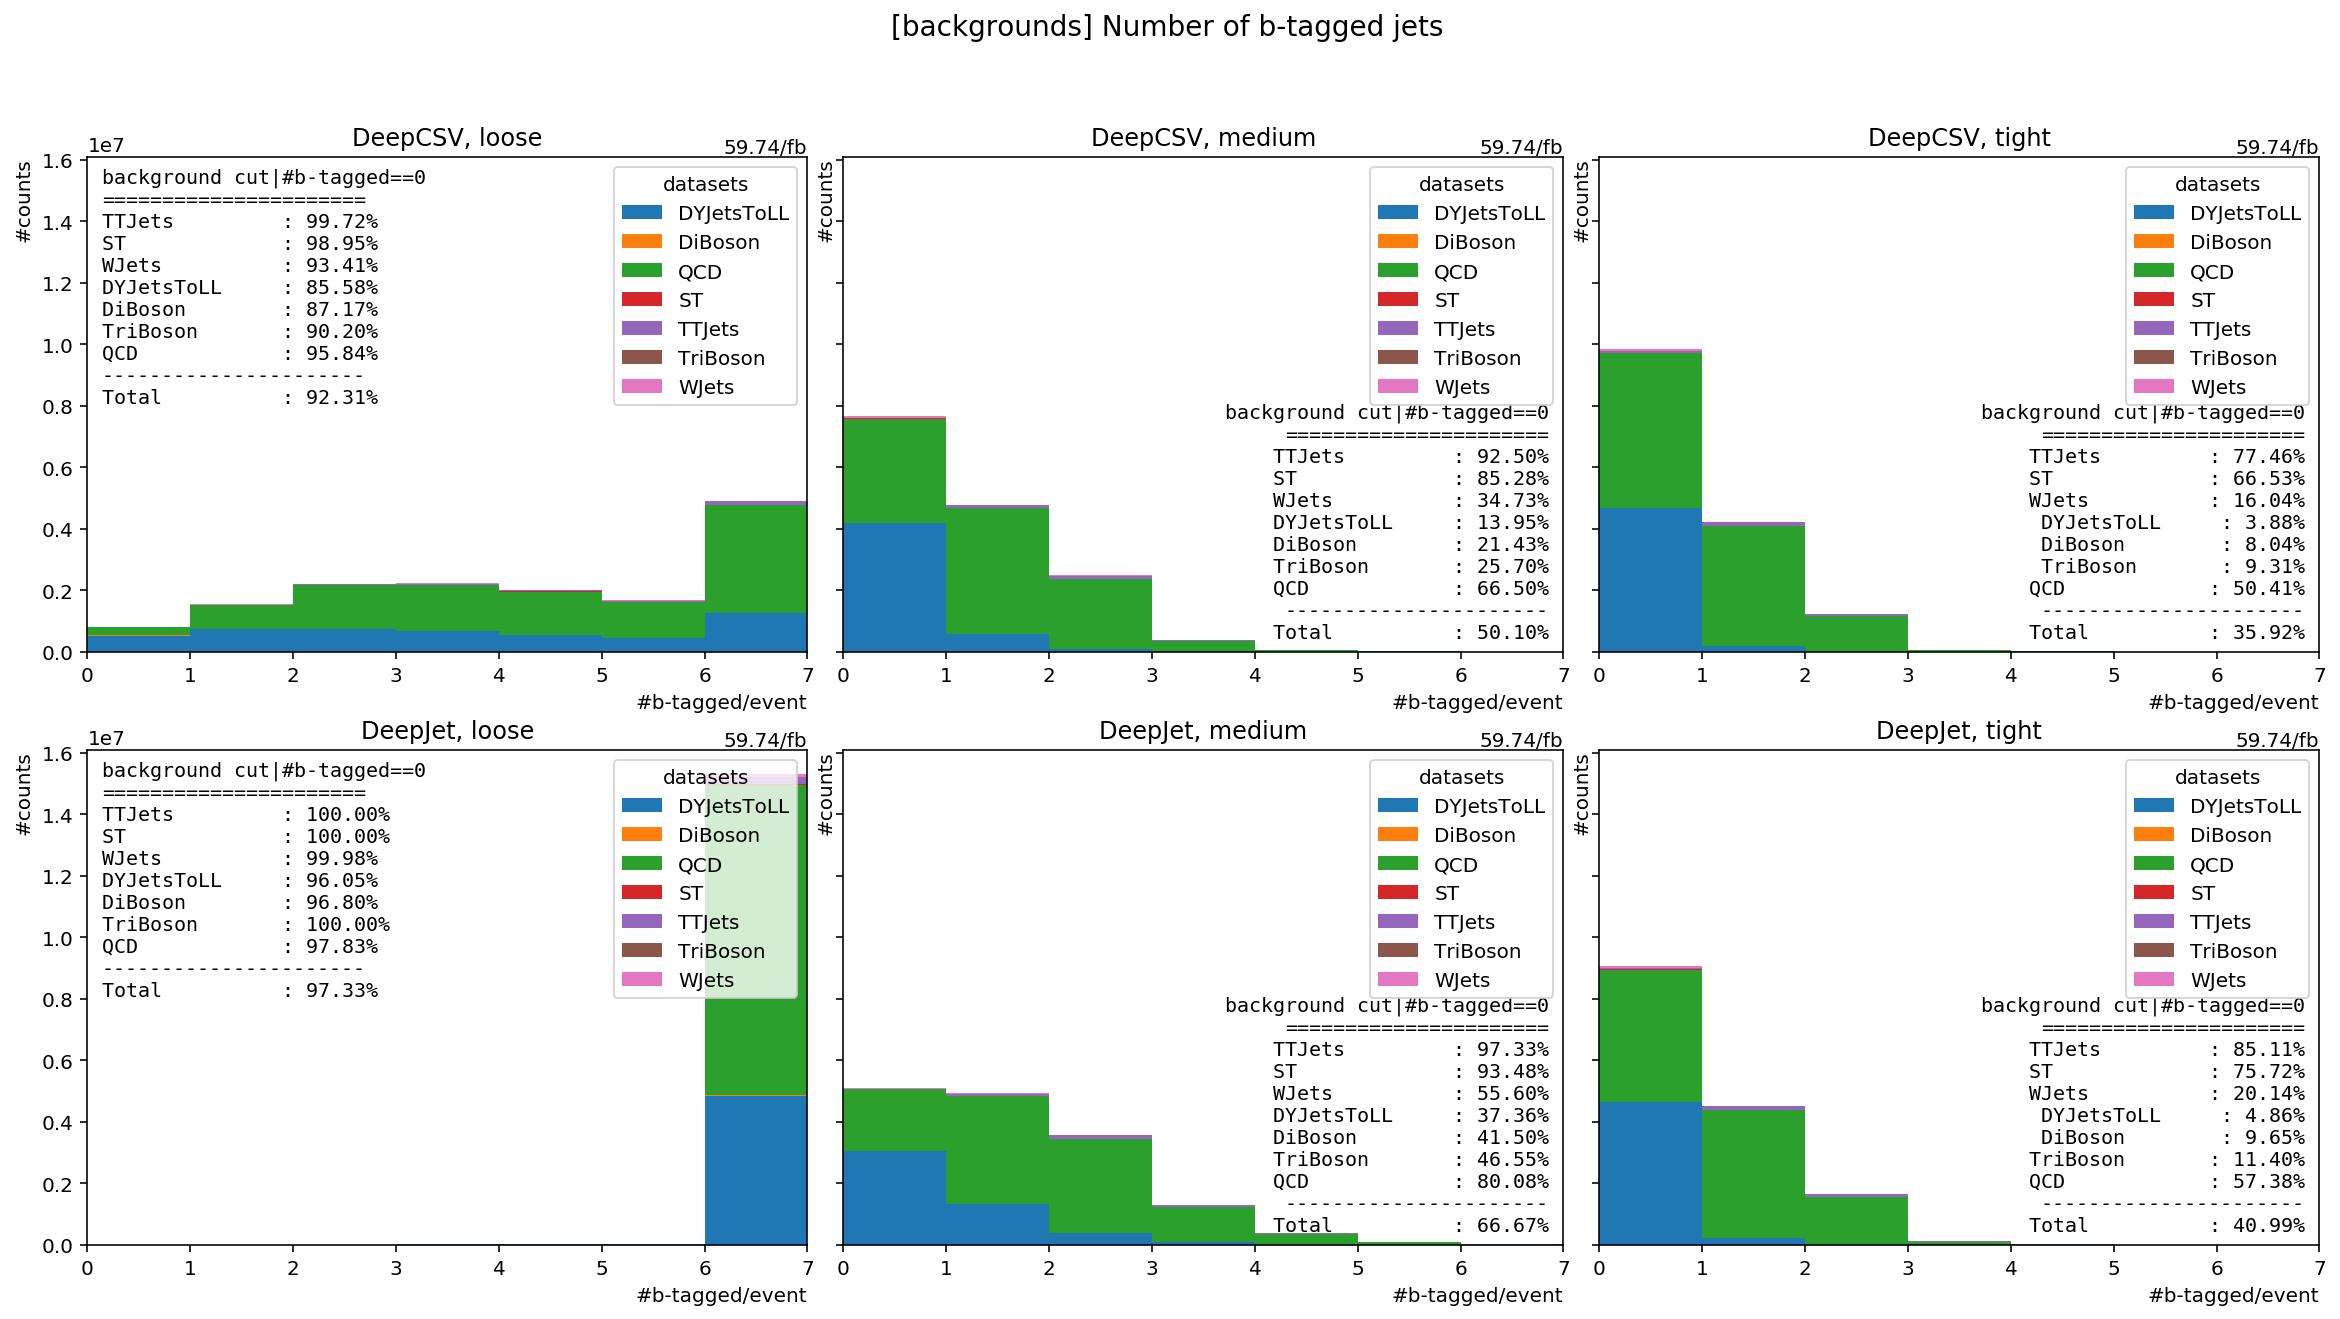

In [35]:
fig, _ = plt.subplots(2,3,figsize=(20,10), gridspec_kw={'wspace': 0.05}, sharey=True)
fig, axes = hist.plotgrid(output['multi_cat'], figure=fig, col='wp', row='tagger', overlay='cat', stack=True, overflow='over',)
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
plt.suptitle('[backgrounds] Number of b-tagged jets', fontsize=14)

# print background cut
from collections import defaultdict
res = defaultdict(lambda: defaultdict(dict))
ressum = defaultdict(dict)
for c, vals in output['multi_cat'].values().items():
    loss = 1-vals[0]/np.sum(vals)
    res[c[2]][c[1]][c[0]] = loss
for c, val in output['multi_cat'].sum('cat').values().items():
    ressum[c[1]][c[0]] = 1-val[0]/np.sum(val)

restext = defaultdict(dict)
for tagger in res:
    for wp in res[tagger]:
        text_ = ['background cut|#b-tagged==0','='*22]
        for x, v in res[tagger][wp].items():
            text_.append("{:15}: {:.2%}".format(x, v))
        text_.append('-'*22)
        text_.append("{:15}: {:.2%}".format("Total", ressum[tagger][wp]))
        restext[tagger][wp] = '\n'.join(text_)
axes[0][0].text(0.02, 0.98, restext['DeepCSV']['loose'], family='monospace', transform=axes[0][0].transAxes, ha='left', va='top')
axes[0][1].text(0.98, 0.02, restext['DeepCSV']['medium'], family='monospace', transform=axes[0][1].transAxes, ha='right', va='bottom')
axes[0][2].text(0.98, 0.02, restext['DeepCSV']['tight'], family='monospace', transform=axes[0][2].transAxes, ha='right', va='bottom')
axes[1][0].text(0.02, 0.98, restext['DeepJet']['loose'], family='monospace', transform=axes[1][0].transAxes, ha='left', va='top')
axes[1][1].text(0.98, 0.02, restext['DeepJet']['medium'], family='monospace', transform=axes[1][1].transAxes, ha='right', va='bottom')
axes[1][2].text(0.98, 0.02, restext['DeepJet']['tight'], family='monospace', transform=axes[1][2].transAxes, ha='right', va='bottom');

leptonjet neutralness

In [90]:
def inspect(file):
    t = uproot.open(file)['ffNtuplizer/ffNtuple']
    akjet = JaggedCandidateArray.candidatesfromcounts(
        t['akjet_p4'].array(),
        px=t['akjet_p4.fCoordinates.fX'].array().flatten(),
        py=t['akjet_p4.fCoordinates.fY'].array().flatten(),
        pz=t['akjet_p4.fCoordinates.fZ'].array().flatten(),
        energy=t['akjet_p4.fCoordinates.fT'].array().flatten(),
        jetid=t['akjet_jetid'].array().flatten(),
        hadfr=t['akjet_hadronEnergyFraction'].array().flatten(),
        chadfr=t['akjet_chaHadEnergyFraction'].array().flatten(),
    )
    print(file)
    print('HT:', akjet.p4.Et[akjet.jetid].sum())
    print('HadronHT:', (akjet.p4.Et*akjet.hadfr)[akjet.jetid].sum())
    print('Charged Hadron HT:', (akjet.p4.Et*akjet.chadfr)[akjet.jetid].sum())

inspect('/uscms/home/wsi/nobackup/lpcdm/CMSSW_10_2_14/src/Firefighter/ffConfig/python/test/ffNtuple_QCDpT300To470.root')
inspect('/uscms/home/wsi/nobackup/lpcdm/CMSSW_10_2_14/src/Firefighter/ffConfig/python/test/ffNtuple_signal-4mu.root')
inspect('/uscms/home/wsi/nobackup/lpcdm/CMSSW_10_2_14/src/Firefighter/ffConfig/python/test/ffNtuple_signal-2mu2e.root')

/uscms/home/wsi/nobackup/lpcdm/CMSSW_10_2_14/src/Firefighter/ffConfig/python/test/ffNtuple_QCDpT300To470.root
HT: [1127.1145 1337.7102 2087.5386 1720.988  2318.544  1255.061  1546.7986
 1687.6595]
HadronHT: [ 825.5802 1110.115  1758.2109 1109.4817 1579.9299  949.3916 1129.2554
 1170.3932]
Charged Hadron HT: [440.3761  521.71545 756.29425 625.01575 613.47815 570.33905 529.97943
 684.673  ]
/uscms/home/wsi/nobackup/lpcdm/CMSSW_10_2_14/src/Firefighter/ffConfig/python/test/ffNtuple_signal-4mu.root
HT: [ 782.8461  1022.1367   487.50394  349.43457  398.86716  528.04956
  719.3192   695.57825 1006.44696  330.9343  1030.8092   824.9727
 1481.6803   960.92834  382.61243  477.4568   824.8893   830.6129
  889.80554  850.2622   891.1634   726.4185   659.40656 1376.6798
  800.88043  819.55206  574.8916  1240.2599   718.8817   912.1261 ]
HadronHT: [ 655.03906  837.83075  412.36743  289.55496  328.22223  434.28287
  608.5627   561.42865  880.8555   288.173    885.7919   707.7128
 1285.5785   790.8493

In [25]:

class LeptonjetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        charge_axis = hist.Bin('charge', 'leptonjet charge sum', 7, -3, 4)
        self._accumulator = processor.dict_accumulator({
            'charge': hist.Hist('counts', dataset_axis, charge_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'].content,
                    py=df['gen_p4.fCoordinates.fY'].content,
                    pz=df['gen_p4.fCoordinates.fZ'].content,
                    energy=df['gen_p4.fCoordinates.fT'].content,
                    pid=df['gen_pid'].content,
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        ljcharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        wgts = (ljcharge.ones_like()*weight).flatten()
        output['charge'].fill(dataset=dataset, charge=ljcharge.flatten(), weight=wgts)
        
        return output
    
    def postprocess(self, accumulator):
        accumulator['charge'].scale(scales, axis='dataset')
        accumulator['charge'] = accumulator['charge'].group("dataset",
                                                              hist.Cat("cat", "datasets"),
                                                              mapping)
        
        return accumulator

In [29]:
output = processor.run_uproot_job(datasets,
                                  treename="ffNtuplizer/ffNtuple",
                                  processor_instance=LeptonjetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 4268/4268 [05:45<00:00, 12.37items/s]


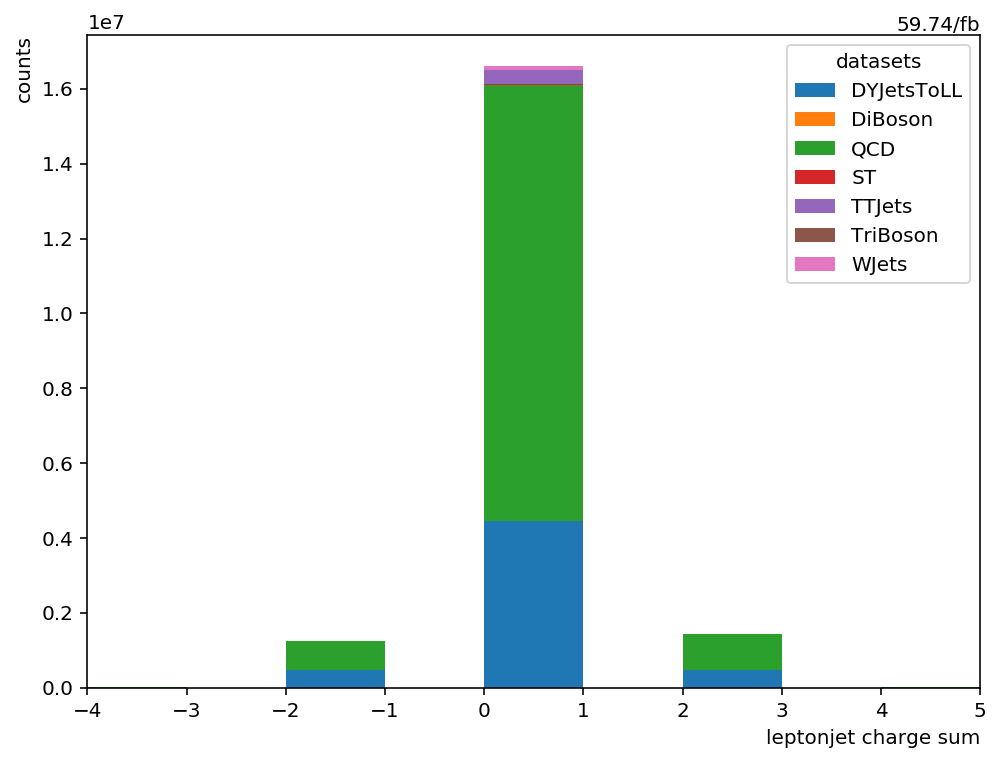

In [41]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['charge'], overlay='cat', stack=True, ax=ax, overflow='all')

ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes);

In [66]:
import pandas as pd
hdf = pd.DataFrame(h.values(overflow='all')).transpose()
hdf.columns = np.arange(-4,5)

In [67]:
hdf

,-4,-3,-2,-1,0,1,2,3,4
TTJets,25.800329,0.0,6760.399224,0.0,3.750315e+05,0.0,6536.554155,0.0,22.057187
ST,1.545267,0.0,636.061667,0.0,3.188117e+04,0.0,636.707137,0.0,1.109265
WJets,10.508016,0.0,3309.943801,0.0,9.768305e+04,0.0,4122.587090,0.0,39.063036
DYJetsToLL,271.880797,0.0,466003.150069,0.0,4.446220e+06,0.0,470332.654798,0.0,264.195310
DiBoson,1.883374,0.0,416.330976,0.0,1.454815e+04,0.0,549.748875,0.0,0.901163
TriBoson,0.007489,0.0,10.299121,0.0,6.837731e+02,0.0,12.318217,0.0,0.016687
QCD,10729.051531,0.0,769425.704038,0.0,1.163599e+07,0.0,952350.619371,0.0,4331.484675


In [73]:
hdf['neutral%'] = hdf[0]/hdf.sum(axis=1)*100
hdf['charged%'] = 100-hdf['neutral%']

In [74]:
hdf[['neutral%', 'charged%']]

,neutral%,charged%
TTJets,96.563949,3.436051
ST,96.153334,3.846666
WJets,92.885379,7.114621
DYJetsToLL,82.596025,17.403975
DiBoson,93.756115,6.243885
TriBoson,96.794869,3.205131
QCD,87.012195,12.987805
